In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'test', 'recursion_dataset_license.pdf', 'train', 'train.csv', 'pixel_stats.csv', 'sample_submission.csv', 'test_controls.csv', 'train_controls.csv']


In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import SGD
from torchvision.transforms import ToTensor
import torchvision.models as models
from pathlib import Path
import PIL.Image
import random
import math
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Open CSVs

In [3]:
path = Path('../input')

In [4]:
tr_df = pd.read_csv(path/'train.csv')
tr_df = tr_df.append(pd.read_csv(path/'train_controls.csv'), ignore_index=True, sort=False)
# tr_df = tr_df.append(pd.read_csv(path/'test_controls.csv'), ignore_index=True)

In [5]:
te_df = pd.read_csv(path/'test.csv')
# te_df = te_df.append(pd.read_csv(path/'test_controls.csv'), ignore_index=True)

# Dataset

In [6]:
def info_from_path(path):
    experiment = path.parts[-3]
    plate = path.parts[-2][-1]
    well = path.parts[-1][:3]
    site = path.parts[-1][5]
    return experiment, plate, well, site

def path_from_info(path, experiment, plate, well, site, channel):
    return path/experiment/('Plate' + plate)/(well + '_s' + site + '_w' + channel + '.png')

In [7]:
info_from_path(path/'train/HEPG2-01/Plate1/B02_s1_w1.png')

('HEPG2-01', '1', 'B02', '1')

In [8]:
path_from_info(path/'train', 'HEPG2-01', '1', 'B02', '1', '1')

PosixPath('../input/train/HEPG2-01/Plate1/B02_s1_w1.png')

In [9]:
class RecursionDataset(Dataset):
    def __init__(self, path, channels, df, labels=None):
        self.images = df[['experiment', 'plate', 'well']].values.tolist()
        self.images = list(map(lambda t: tuple(map(str, t)), self.images))
        self.channels = list(map(str, channels))
        self.len = 2 * len(self.images)
        self.path = path
        self.labels = labels
        
    def __getitem__(self, index):
        site = '1' if index % 2 != 0 else '2'
        experiment, plate, well = self.images[index // 2]
        if self.labels is not None:
            label = self.labels[index // 2]
        else:
            label = 0
        img_channels = []
        for channel in self.channels:
            path = path_from_info(self.path, experiment, plate, well, site, channel)
            img_channels.append(ToTensor()(PIL.Image.open(path)))
        return torch.cat(img_channels), label
    
    def __len__(self):
        return self.len

In [10]:
channels = [1]# , 2, 3, 4, 5, 6]

In [11]:
va_ratio = 0.05

In [12]:
tr_df, va_df = train_test_split(tr_df, 
#                                 train_size=0.05, 
                                test_size=va_ratio, 
                                random_state=42, 
                                stratify=tr_df['sirna'])

In [13]:
tr_ds = RecursionDataset(Path('../input/train'), channels, tr_df, tr_df['sirna'].values)

In [14]:
va_ds = RecursionDataset(Path('../input/train'), channels, va_df, va_df['sirna'].values)

In [15]:
te_ds = RecursionDataset(Path('../input/test'), channels, te_df)

In [16]:
len(tr_ds), len(va_ds), len(te_ds)

(77162, 4062, 39794)

In [17]:
num_classes = 1139

# Dataloader

In [18]:
bs = 64
nw = 0

In [19]:
tr_dl = DataLoader(tr_ds, batch_size=bs, num_workers=nw, drop_last=True, pin_memory=True)

In [20]:
va_dl = DataLoader(va_ds, batch_size=bs, num_workers=nw, drop_last=True, pin_memory=True)

In [21]:
te_dl = DataLoader(te_ds, batch_size=bs, num_workers=nw, drop_last=True, pin_memory=True)

# Arcface

In [22]:
class ArcMarginProduct(nn.Module):
    def __init__(self, s=32.0, m=0.50, easy_margin=True):
        super(ArcMarginProduct, self).__init__()
        self.s = s
        self.m = m

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        # make the function cos(theta+m) monotonic decreasing while theta in [0°,180°]
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, cosine, label):
        # cos(theta + m)
#         cosine = torch.clamp(cosine, -1.0, 1.0)
#         print("cos:", cosine)#, cosine >= 1., cosine <= -1.)
#         assert(not (cosine.clone().detach().cpu().numpy() >= 1.).any())
#         assert(not (cosine.clone().detach().cpu().numpy() <= -1.).any())
#         sine_2 = F.relu(1.0 - torch.pow(cosine, 2))
#         print(sine_2)#, sine_2 > 1.0)
#         assert(not (sine_2.detach().cpu().numpy() > 1.0).any())
#         sine = torch.sqrt(sine_2)
#         sine = torch.clamp(sine, -1.0, 1.0)
#         print("sin:", sine)#, sine >= 1., sine <= -1.)
#         assert(not (sine.clone().detach().cpu().numpy() >= 1.).any())
#         assert(not (sine.clone().detach().cpu().numpy() <= -1.).any())
#         phi = cosine * self.cos_m - sine * self.sin_m
        phi = cosine - self.m

#         if self.easy_margin:
#             phi = torch.where(cosine > 0, phi, cosine)
#         else:
#             phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)

        #one_hot = torch.zeros(cosine.size(), device='cuda' if torch.cuda.is_available() else 'cpu')
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output = output * self.s
        
        output = F.cross_entropy(output, label)
#         print("loss:", output)
        return output

# Embedding

In [23]:
class CosineEmbedding(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(CosineEmbedding, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.weight)
        
    def forward(self, inputs):
#         print("emb weight:", self.weight)
#         print("inp:", inputs)
        return F.linear(F.normalize(inputs), F.normalize(self.weight))

    def normalize(self):
        with torch.no_grad():
            torch.div(self.weight, self.weight.norm(p=None, dim=1, keepdim=True), out=self.weight)

# Model

In [24]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 67977583.10it/s]


In [25]:
new_conv = nn.Conv2d(len(channels), 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
with torch.no_grad():
    new_conv.weight = nn.Parameter(model.conv1.weight.data.mean(dim=1, keepdim=True).repeat(1, len(channels), 1, 1))
model.conv1 = new_conv

In [26]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [27]:
embedding_dim = 128

In [28]:
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=512, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(),
#     nn.Linear(in_features=512, out_features=num_classes, bias=True))
    nn.Linear(in_features=512, out_features=embedding_dim, bias=False))
# model.fc = nn.Linear(in_features=512, out_features=embedding_dim, bias=False)
model.cuda();

In [29]:
embedding = CosineEmbedding(embedding_dim, num_classes)
embedding.cuda();

# Freeze layers

In [30]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
for param in model.conv1.parameters():
    param.requires_grad = True

# Loss

In [31]:
criterion = ArcMarginProduct(s=64.0, m = 0.)# 0.5 * ((2 * math.pi) / num_classes))
# criterion = nn.CrossEntropyLoss()

# Optimizer

In [32]:
lr = 1e-1

In [33]:
# optimizer = Adam(model.fc.parameters(), lr=lr)
optimizer = SGD(model.fc.parameters(), lr=lr)

In [34]:
optimizer.add_param_group({'params': embedding.parameters(), 'lr': 1e-2})

In [35]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

# Train

In [36]:
num_epochs = 20
model_dir = Path('/kaggle/working/')

In [37]:
tr_metrics = []
va_metrics = []

In [38]:
for epoch in tqdm(range(num_epochs)):
# for epoch in range(num_epochs):
    print('Epoch: {:02d}\n'.format(epoch))
    
    iterations = 0
    running_loss = 0.0
    running_acc = 0
    model.train()
    for inputs, targets in tqdm(tr_dl):
#     for inputs, targets in tr_dl:
        inputs = inputs.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = embedding(outputs)
        loss = criterion(outputs, targets)
        loss.backward()
        embedding.normalize()
        optimizer.step()
        
        loss = loss.item()
        running_loss += loss
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == targets.data, dtype=torch.float32) / inputs.shape[0]
        running_acc += acc
        tr_metrics.append((loss, acc))
        iterations += 1
    
    tr_loss = running_loss / iterations
    tr_acc = running_acc / iterations
    print('Train: Loss: {:.6f} Acc: {:.6f}'.format(tr_loss, tr_acc))
    
    iterations = 0
    running_loss = 0.0
    running_acc = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(va_dl):
#         for inputs, targets in va_dl:
            inputs = inputs.cuda()
            targets = targets.cuda()
            outputs = model(inputs)
            outputs = embedding(outputs)
            
            loss = criterion(outputs, targets)
            loss = loss.item()
            running_loss += loss
            _, preds = torch.max(outputs, 1)
            acc = torch.sum(preds == targets.data, dtype=torch.float32) / inputs.shape[0]
            running_acc += acc

            iterations += 1
            
    va_loss = running_loss / iterations
    va_acc = acc / iterations
    va_metrics.append((va_loss, va_acc))
    print('Val: Loss: {:.6f} Acc: {:.6f}'.format(va_loss, va_acc))    

Epoch: 00



Train: Loss: 7.879431 Acc: 0.003644


Val: Loss: 7.153470 Acc: 0.000248
Epoch: 01



Train: Loss: 7.142833 Acc: 0.005407


Val: Loss: 7.065210 Acc: 0.000248
Epoch: 02



In [39]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'embedding_state_dict': embedding.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, str(model_dir/'epoch-{}.pth'.format(epoch)))

In [40]:
!nvidia-smi

Thu Aug  8 18:06:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    41W / 250W |  10685MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

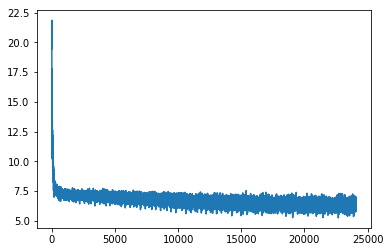

In [41]:
plt.plot(list(map(lambda t:t[0], tr_metrics)))

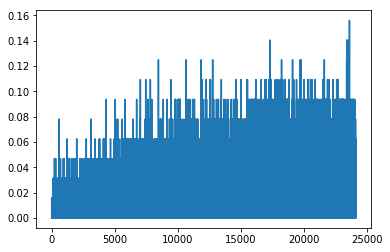

In [42]:
plt.plot(list(map(lambda t:t[1], tr_metrics)))

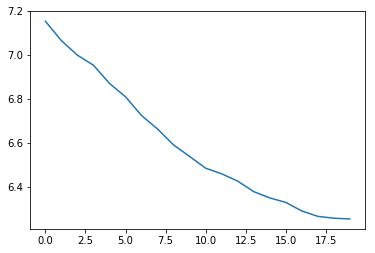

In [43]:
plt.plot(list(map(lambda t:t[0], va_metrics)))

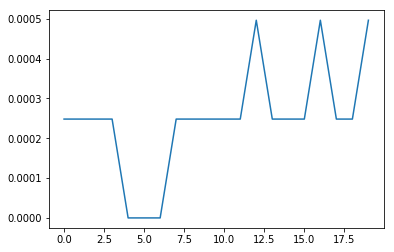

In [44]:
plt.plot(list(map(lambda t:t[1], va_metrics)))